In [1]:
#Importacion de librerias

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
#Funciones Auxiliares

#Funcion para crear filtros gaussianos, retorna filtro en dominio espacial y dominio espectral (FFT)
def create_gauss_filter(h, w, k_size=5, sigma=2):
    k_1d = cv.getGaussianKernel(ksize=k_size, sigma=sigma) 
    ker = k_1d * k_1d.T

    matriz = np.zeros((h, w))  # Crear una matriz de ceros de tamaño hxw
    centro_h = h // 2 
    centro_w = w // 2 
    ker_h = ker.shape[0] // 2 
    ker_w = ker.shape[1] // 2 

    inicio_fila = centro_h - ker_h
    fin_fila = inicio_fila + ker.shape[0]
    inicio_col = centro_w - ker_w
    fin_col = inicio_col + ker.shape[1]

    matriz[inicio_fila:fin_fila, inicio_col:fin_col] = ker[:,:]

    kernel_tf = np.fft.fft2(matriz)
 
    return matriz, kernel_tf


#Funcion para calcular Image Quality measure (FM) según el paper Image Sharpness Measure for Blurred Images in Frequency
def calculate_fm(img_filtered):

    f = np.fft.fft2(img_filtered)
    fc = np.fft.fftshift(f)
    af = np.abs(fc)
    m = np.max(af)
    thres = m/1000
    th = np.sum(f > thres)
    fm = th / (img_filtered.shape[0] * img_filtered.shape[1])
    return fm


#Funcion para comparar los factores FM (Image Quality measure) de la multiplicacion de los filtros en dominio espectral contra la funcion GaussianBlur de opencv
def comparition_filters(img_orig, kernel_c, k_size = 15, sigma=2):
    fft_c1 = np.fft.fft2(img_orig)
    k_c_filt1 = fft_c1 * kernel_c
    gauss_filt_c1 = np.fft.ifftshift(np.real(np.fft.ifft2(k_c_filt1)))

    gauss_filt_c2 = cv.GaussianBlur(img_orig, (k_size,k_size), sigmaX = sigma)

    fm1 = calculate_fm(gauss_filt_c1)
    fm2 = calculate_fm(gauss_filt_c2)

    print(f"Tomando en cuenta un sigma = {sigma}")
    print(f"El factor FM para el kernel ingresado es = {fm1}")
    print(f"El factor FM usando la funcion GaussianBlur es = {fm2}")
    print(f"La diferencia con respecto a GaussianBlur es = {((fm1-fm2)/fm2*100):.4f} %")
    return fm1 , fm2, sigma


#Funcion para calcular enfoque de una imagen por medio de operador Tenengrad (GRA6) del apendice A del paper Analysis of focus measure operators for shape-from-focus
#tomando como referencia la media del contraste de Tenengrad
def tenengrad(img):

    # Calcular los gradientes en las direcciones x e y utilizando Sobel
    grad_x = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
    grad_y = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)

    # Calcular el cuadrado de los gradientes
    grad_x_squared = np.square(grad_x)
    grad_y_squared = np.square(grad_y)

    # Calcular el contraste de Tenengrad
    tenengrad_operator = np.sqrt(grad_x_squared + grad_y_squared)

    # Calcular la media del contraste de Tenengrad como medida de enfoque
    focus = np.mean(tenengrad_operator)

    return focus


In [5]:
#Cargar imagen en escala de grises
img = cv.imread('assets\\nights_king.jpg', cv.IMREAD_GRAYSCALE)

h, w = img.shape

In [6]:
#Generamos filtros gaussianos dejando fijo el k_size y variando el sigma = 2 , 3 , 4, 5 y 10

kernel_s2, kernel_s2_tf= create_gauss_filter(h, w, k_size=15, sigma=2)
kernel_s3, kernel_s3_tf= create_gauss_filter(h, w, k_size=15, sigma=3)
kernel_s4, kernel_s4_tf= create_gauss_filter(h, w, k_size=15, sigma=4)
kernel_s5, kernel_s5_tf= create_gauss_filter(h, w, k_size=15, sigma=5)
kernel_s10, kernel_s10_tf= create_gauss_filter(h, w, k_size=15, sigma=10)

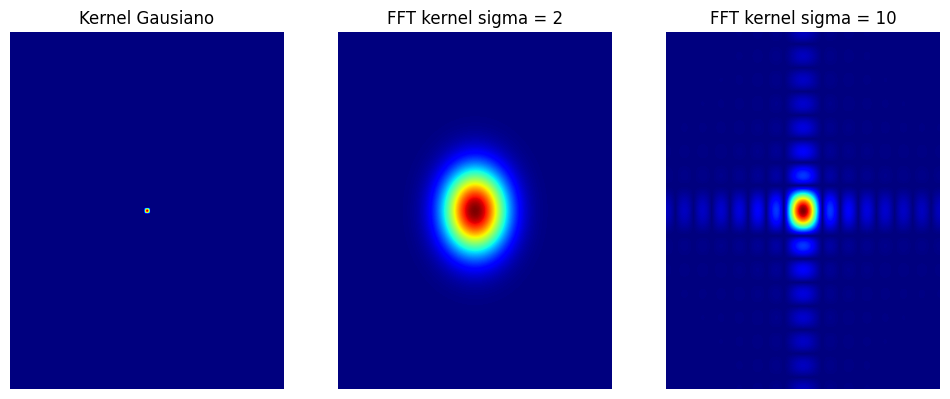

In [7]:
#Graficamos los kernels gaussiano en dominio espacial y sus correspondientes FFT con sigma = 2 y 10

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel_s5, cmap='jet')
plt.subplot(1,3,2)
plt.axis('off')
plt.title("FFT kernel sigma = 2")
tf_shifted = np.fft.fftshift(kernel_s2_tf)
plt.imshow(np.abs(tf_shifted), cmap='jet')
plt.subplot(1,3,3)
plt.axis('off')
plt.title("FFT kernel sigma = 10")
tf_shifted = np.fft.fftshift(kernel_s10_tf)
plt.imshow(np.abs(tf_shifted), cmap='jet')

1. Aplicar los filtros a una imagen para validar el funcionamiento en el dominio espectral.

Text(0.5, 1.0, 'Desenfoque gaussiano con sigma = 10')

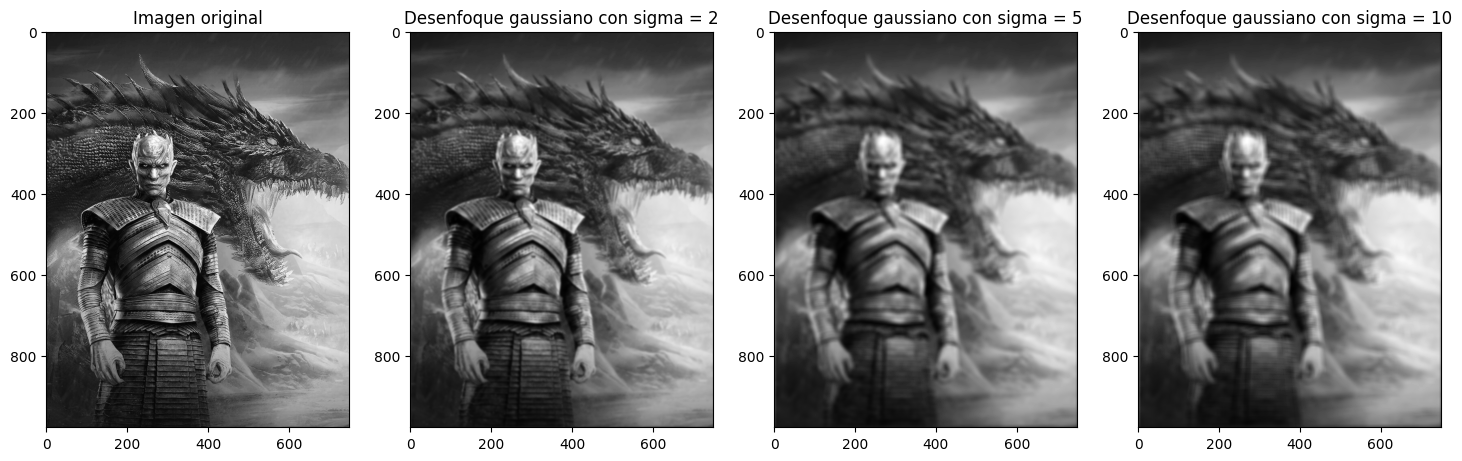

In [8]:
#Representacion del desenfoque gaussiano sobre una imagen

img_fft = np.fft.fft2(img)
img_fltred_s2 = img_fft * kernel_s2_tf
img_gauss_s2 = np.fft.ifftshift(np.real(np.fft.ifft2(img_fltred_s2)))

img_fltred_s3 = img_fft * kernel_s3_tf
img_gauss_s3 = np.fft.ifftshift(np.real(np.fft.ifft2(img_fltred_s3)))

img_fltred_s4 = img_fft * kernel_s4_tf
img_gauss_s4 = np.fft.ifftshift(np.real(np.fft.ifft2(img_fltred_s4)))

img_fltred_s5 = img_fft * kernel_s5_tf
img_gauss_s5 = np.fft.ifftshift(np.real(np.fft.ifft2(img_fltred_s5)))

img_fltred_s10 = img_fft * kernel_s10_tf
img_gauss_s10 = np.fft.ifftshift(np.real(np.fft.ifft2(img_fltred_s10)))

plt.figure(figsize=(18,8))

plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('Imagen original')
plt.subplot(1,4,2)
plt.imshow(img_gauss_s2, cmap='gray')
plt.title('Desenfoque gaussiano con sigma = 2')
plt.subplot(1,4,3)
plt.imshow(img_gauss_s5, cmap='gray')
plt.title('Desenfoque gaussiano con sigma = 5')
plt.subplot(1,4,4)
plt.imshow(img_gauss_s10, cmap='gray')
plt.title('Desenfoque gaussiano con sigma = 10')

2. Comparacion de multiplicacion de Kernels Gaussianos contra la funcion GaussianBlur de OpenCV

In [9]:
comp_FM_factors = []

In [10]:
results = comparition_filters(img, kernel_s2_tf, 15, sigma = 2)
comp_FM_factors.append(results)

Tomando en cuenta un sigma = 2
El factor FM para el kernel ingresado es = 0.002468984321745058
El factor FM usando la funcion GaussianBlur es = 0.0024880708929788686
La diferencia con respecto a GaussianBlur es = -0.7671 %


In [11]:
results = comparition_filters(img, kernel_s3_tf, 15, sigma = 3)
comp_FM_factors.append(results)

Tomando en cuenta un sigma = 3
El factor FM para el kernel ingresado es = 0.0019154737559645535
El factor FM usando la funcion GaussianBlur es = 0.0019427402862985685
La diferencia con respecto a GaussianBlur es = -1.4035 %


In [12]:
results = comparition_filters(img, kernel_s4_tf, 15, sigma = 4)
comp_FM_factors.append(results)

Tomando en cuenta un sigma = 4
El factor FM para el kernel ingresado es = 0.001645535105657805
El factor FM usando la funcion GaussianBlur es = 0.001656441717791411
La diferencia con respecto a GaussianBlur es = -0.6584 %


In [13]:
results = comparition_filters(img, kernel_s5_tf, 15, sigma = 5)
comp_FM_factors.append(results)

Tomando en cuenta un sigma = 5
El factor FM para el kernel ingresado es = 0.0014955691888207225
El factor FM usando la funcion GaussianBlur es = 0.0015337423312883436
La diferencia con respecto a GaussianBlur es = -2.4889 %


In [14]:
results = comparition_filters(img, kernel_s10_tf, 15, sigma = 10)
comp_FM_factors.append(results)

Tomando en cuenta un sigma = 10
El factor FM para el kernel ingresado es = 0.0013156100886162236
El factor FM usando la funcion GaussianBlur es = 0.0013592365371506475
La diferencia con respecto a GaussianBlur es = -3.2096 %


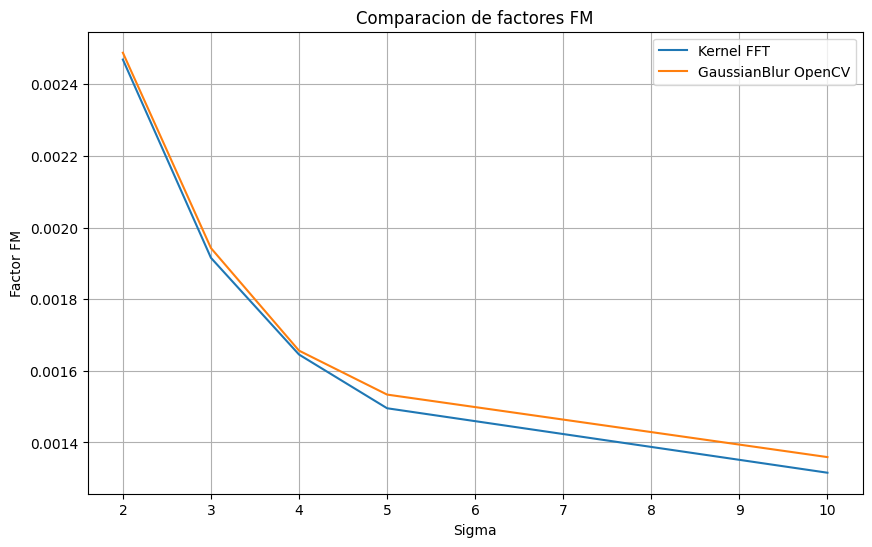

In [15]:
# Graficar los valores

arr = np.array(comp_FM_factors)
lab = ["Kernel FFT", "GaussianBlur OpenCV"]

plt.figure(figsize=(10, 6))

for i in range(2):  
    plt.plot([2,3,4,5,10], arr[:, i], label=lab[i])

plt.xlabel("Sigma")
plt.ylabel("Factor FM")
plt.title("Comparacion de factores FM")
plt.legend()
plt.grid(True)
plt.show()

3. Comparacion de grado de desenfoque (blur) segun operador Tenengrad 

In [16]:
arr_sigmas = [2,3,4,5,10]
arr_tenengrad = list(range(5))

In [17]:
arr_tenengrad[0] = tenengrad(img_gauss_s2)
arr_tenengrad[1] = tenengrad(img_gauss_s3)
arr_tenengrad[2] = tenengrad(img_gauss_s4)
arr_tenengrad[3] = tenengrad(img_gauss_s5)
arr_tenengrad[4] = tenengrad(img_gauss_s10)

In [18]:
#Calculos de factores Tenengrad para la imagen original sin blur y las imagenes desenfocadas con los diferentes grados de blur (sigmas)

print(f"El factor Tenengrad para la imagen sin blur es = {tenengrad(img)}")
print(f"El factor Tenengrad para las imagenes desenfocadas con filtros gaussianos")
print(f"con sigmas {arr_sigmas} son = {np.round(arr_tenengrad, decimals=2)} correspondientemente")

El factor Tenengrad para la imagen sin blur es = 94.10262854321654
El factor Tenengrad para las imagenes desenfocadas con filtros gaussianos
con sigmas [2, 3, 4, 5, 10] son = [27.7  20.47 17.76 16.78 16.11] correspondientemente


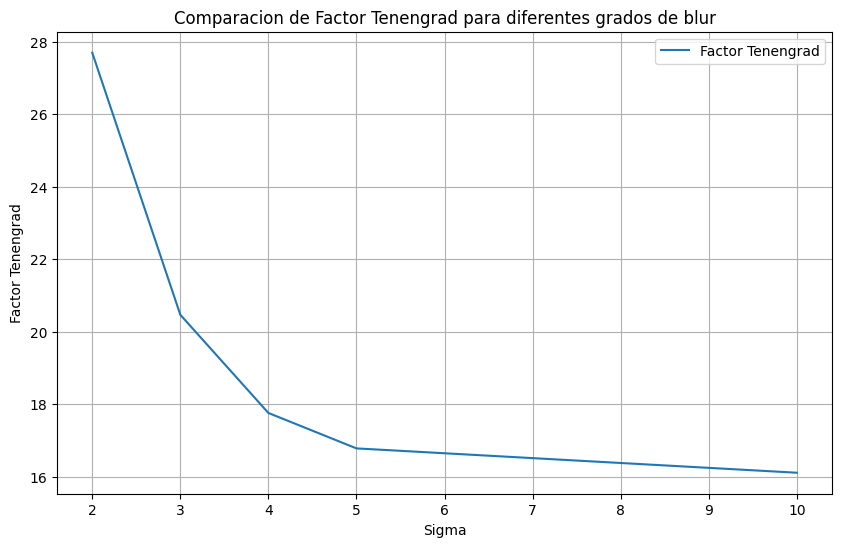

In [19]:
# Graficar los valores

arr = np.array(arr_tenengrad)

plt.figure(figsize=(10, 6))

plt.plot(arr_sigmas, arr[:], label="Factor Tenengrad")

plt.xlabel("Sigma")
plt.ylabel("Factor Tenengrad")
plt.title("Comparacion de Factor Tenengrad para diferentes grados de blur")
plt.legend()
plt.grid(True)
plt.show()